In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
photo = cv2.imread('photo.jpg', 3)
university_logo = cv2.imread('ucu.jpg')
apps_logo = cv2.imread('apps.jpg')

In [3]:
def show_image(opencv_image):
    b,g,r = cv2.split(opencv_image)
    rgb_image = cv2.merge([r,g,b])
    plt.figure(figsize=(30,10))
    plt.imshow(rgb_image)
    plt.show()

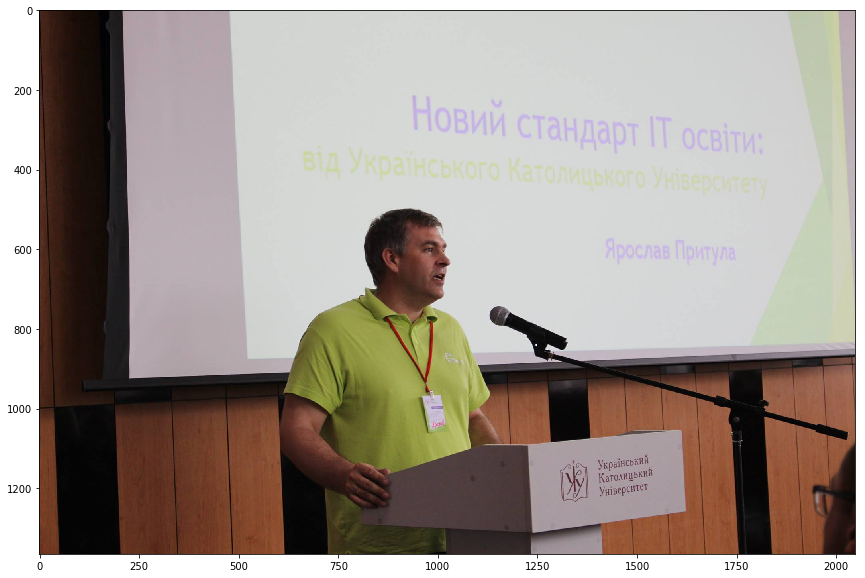

In [4]:
show_image(photo)

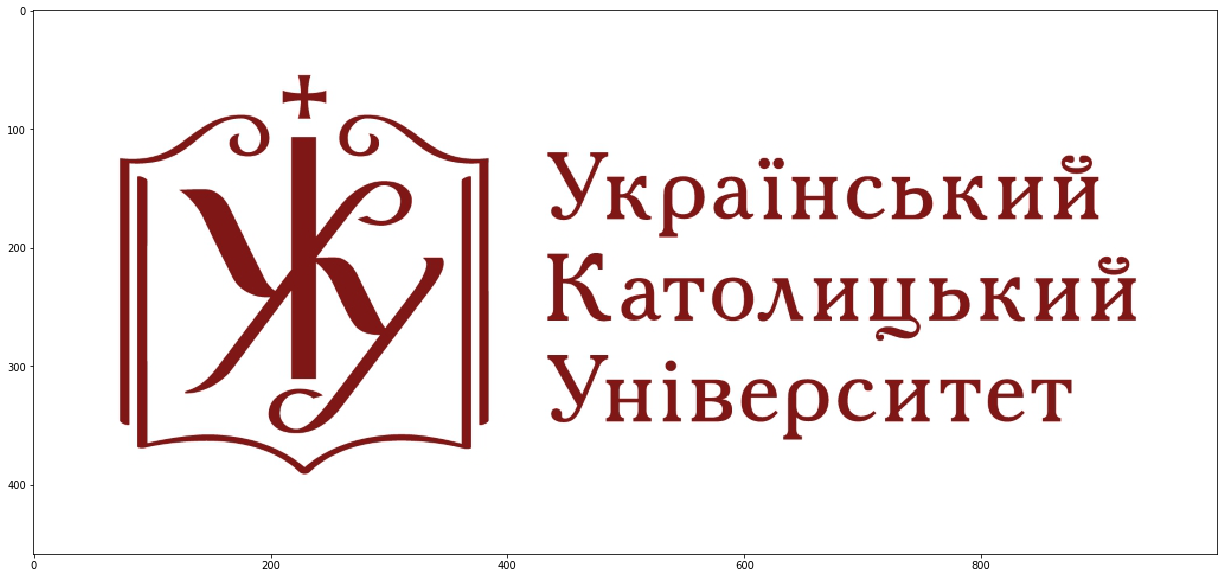

In [5]:
show_image(university_logo)

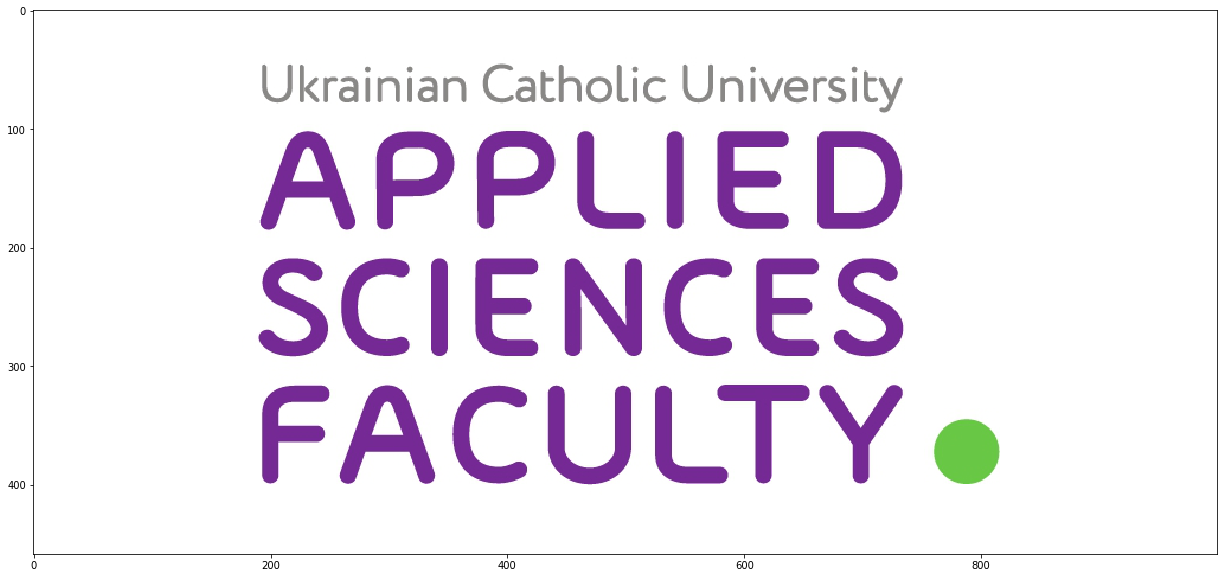

In [6]:
show_image(apps_logo)

## Using ORB for finding descriptors

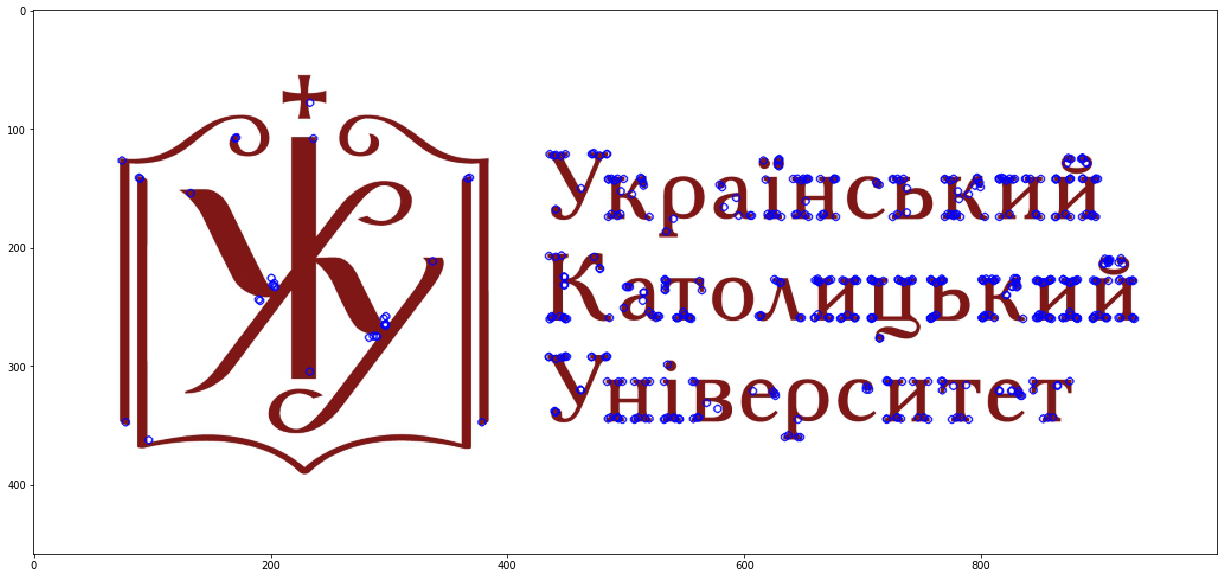

(None, None)

In [7]:
orb = cv2.ORB_create()

logo_kp = orb.detect(university_logo,None)
logo_kp, logo_des = orb.compute(university_logo, logo_kp)

university_logo2 = cv2.drawKeypoints(university_logo, logo_kp,None,color=(255,0,0), flags=0)
show_image(university_logo2),plt.show()

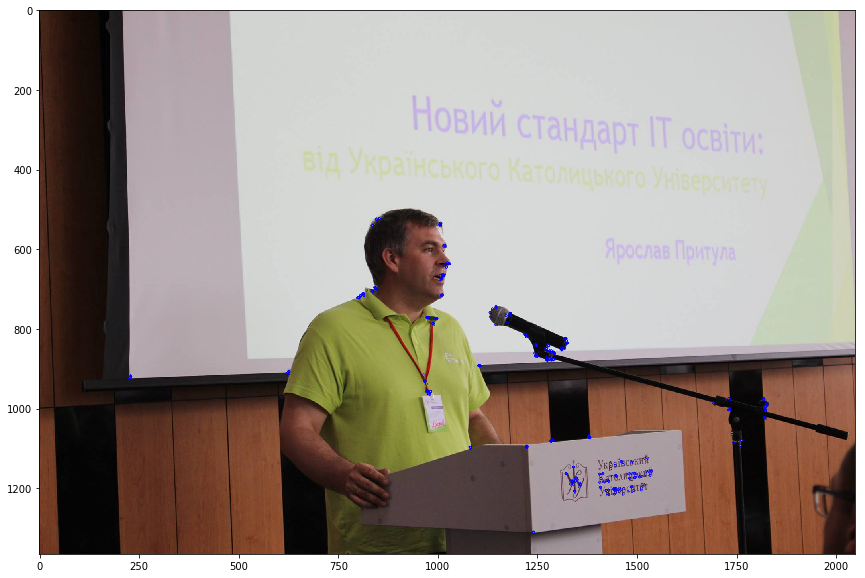

(None, None)

In [8]:
photo_kp = orb.detect(photo,None)

photo_kp, photo_des = orb.compute(photo, photo_kp)

photo2 = cv2.drawKeypoints(photo,photo_kp,None,color=(255,0,0), flags=0)
show_image(photo2),plt.show()

## Matching with BFMatcher

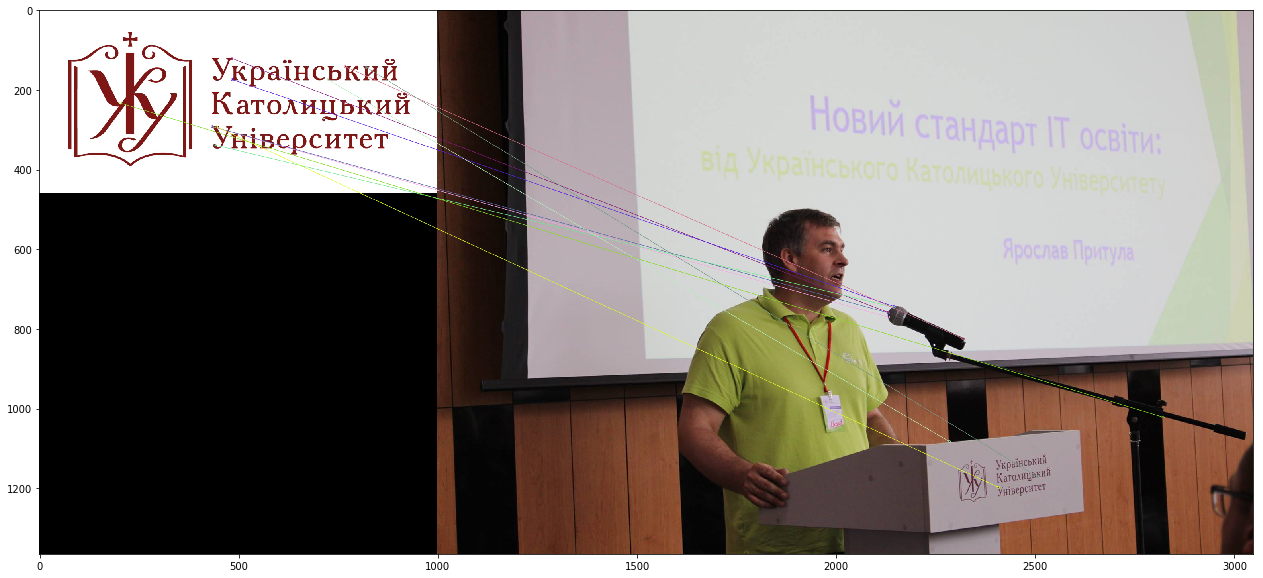

(None, None)

In [9]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(logo_des,photo_des)
matches = sorted(matches, key = lambda x:x.distance)

match_pic = cv2.drawMatches(university_logo,logo_kp,photo,photo_kp,matches[:10],None, flags=2)
show_image(match_pic),plt.show()

This works poorly, even 10 best matches are not correct, so my next trial is with SIFT and Flann based matcher:

## Improvement

#### Finding descriptors with SIFT

In [10]:
# better descriptors are found when using black and white photots
gr_ucu = cv2.imread('ucu.jpg',0)
gr_photo = cv2.imread('photo.jpg',0) 

sift = cv2.xfeatures2d.SIFT_create()

kp_ucu, des_ucu = sift.detectAndCompute(gr_ucu,None)
kp_photo, des_photo = sift.detectAndCompute(gr_photo,None)

#### Matching and filtering matches 

In [11]:
flann = cv2.FlannBasedMatcher(dict(algorithm=0, trees=5), dict(checks=50))

matches = flann.knnMatch(des_ucu, des_photo, k=2)

good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

#### Calculating homography matrix and mask

In [12]:
ucu_des_coords = np.array([kp_ucu[mat.queryIdx].pt for mat in good]) 
photo_des_coords = np.array([kp_photo[mat.trainIdx].pt for mat in good])

H, mask = cv2.findHomography(ucu_des_coords, photo_des_coords, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()

height,width = gr_ucu.shape[:2]
pts = np.float32([ [0,0],[0,height-1],[width-1,height-1],[width-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,H)

#### Drawing matches

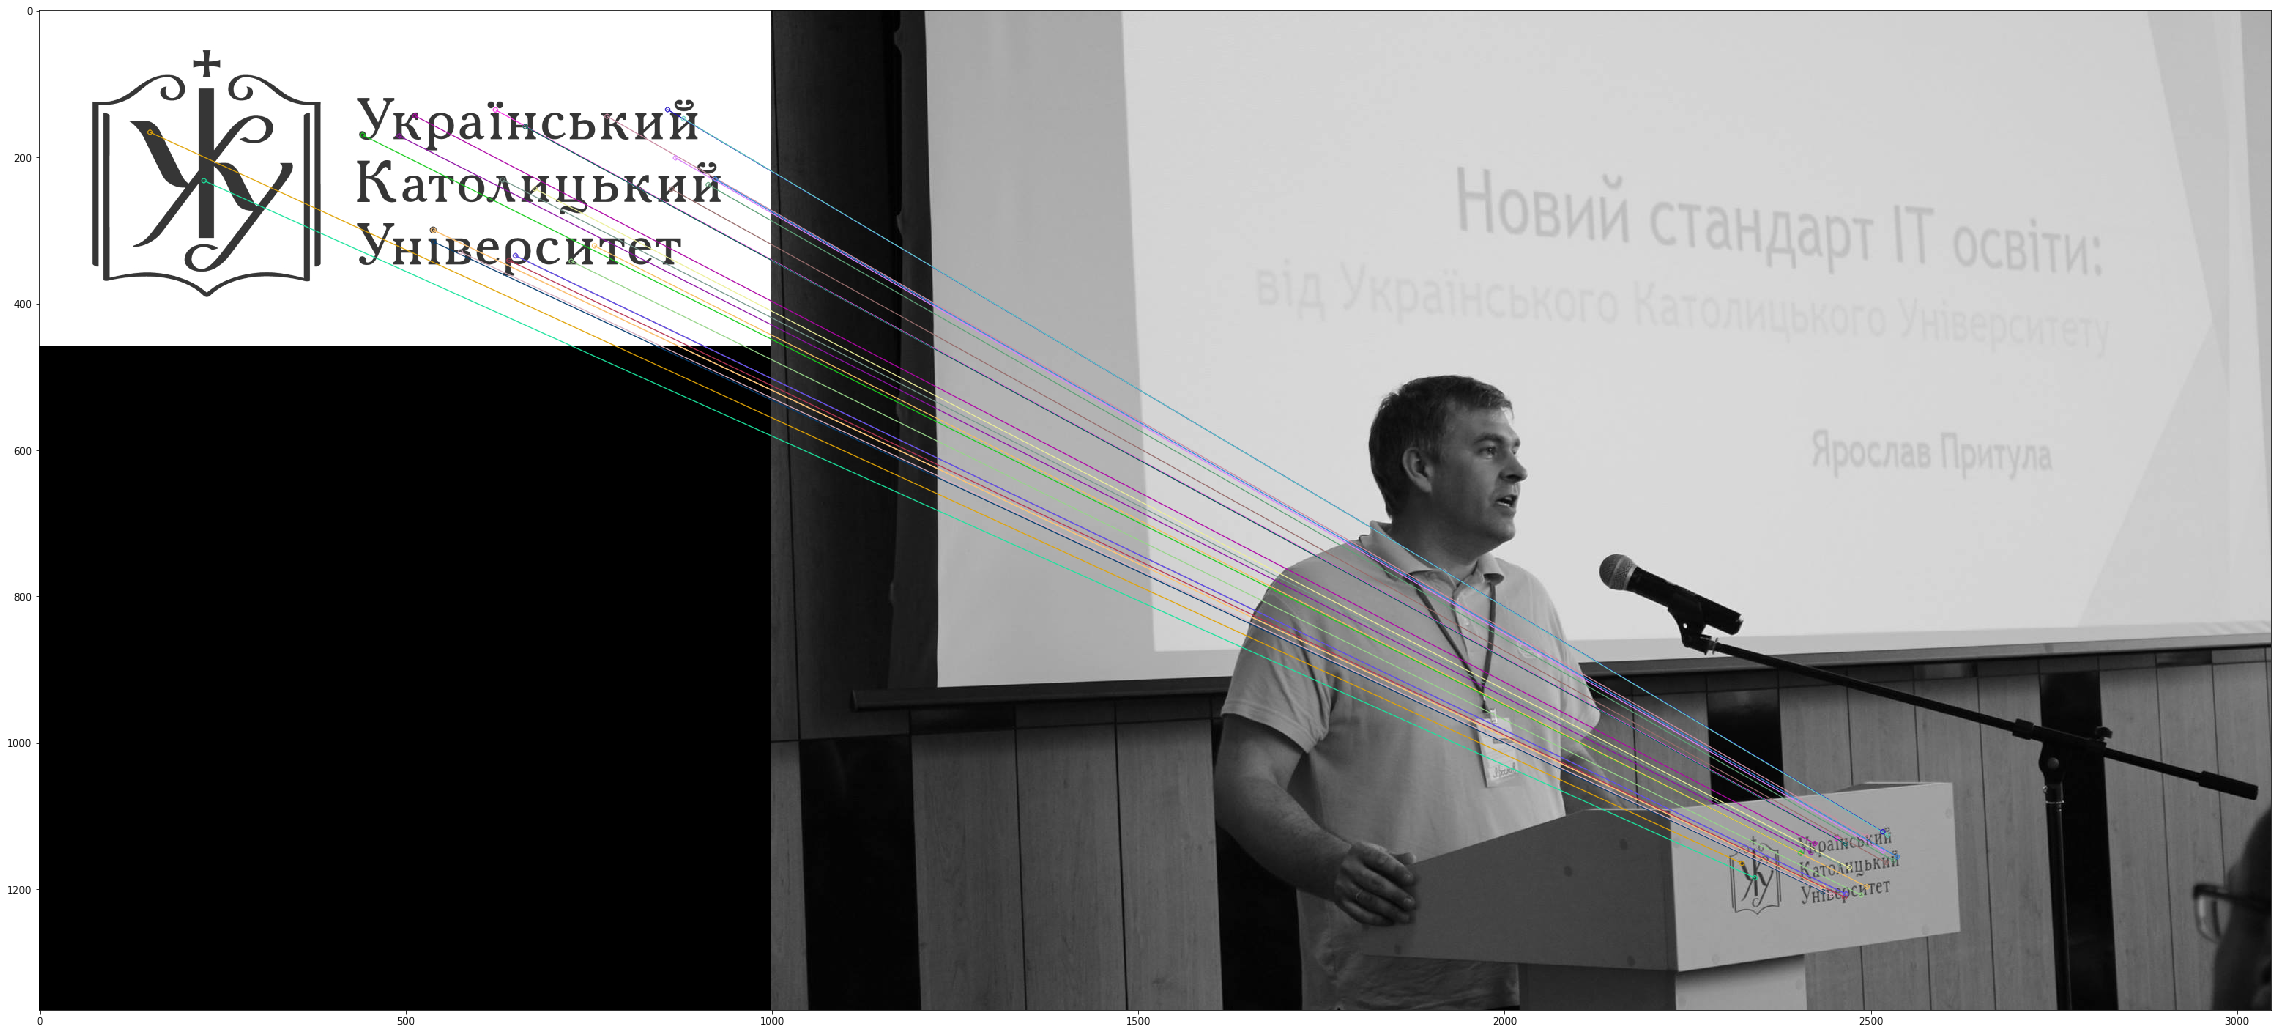

(<matplotlib.image.AxesImage at 0x7f40e4c3c5f8>, None)

In [13]:
draw_params = dict(matchesMask = matchesMask,flags = 2)

matches_img = cv2.drawMatches(gr_ucu,kp_ucu,gr_photo,kp_photo,good,None,**draw_params)
plt.figure(figsize=(40,20))

plt.imshow(matches_img),plt.show()

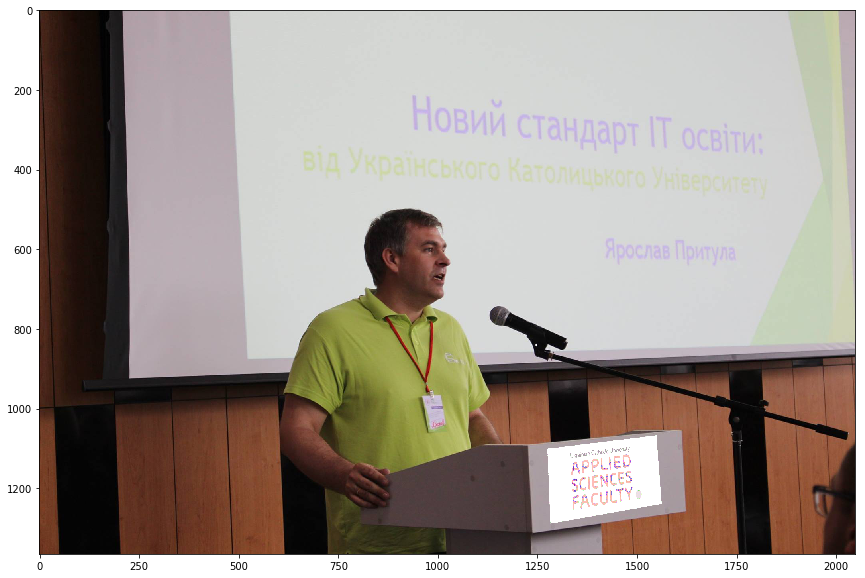

In [14]:
reshaped_logo = cv2.warpPerspective(apps_logo, H, (gr_photo.shape[1],gr_photo.shape[0]))
replaced = cv2.bitwise_or(reshaped_logo, photo)
show_image(replaced)